In [1]:
# 🧪 Avaluació final del model entrenat

# 🔧 Preparar entorn perquè src sigui importable
import sys
from sklearn.metrics import classification_report
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.data.dataset_loader import load_medmnist_dataset
from src.model.dwtformer import DWTFormer
from src.train.evaluate import (
    evaluate_model,
    print_f1_per_class,
    plot_confusion,
    plot_multiclass_roc
)

In [2]:
# 📌 Paràmetres generals
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 128
NUM_CLASSES = {
    "pathmnist": 9,
    "chestmnist": 14,
    "organamnist": 11
}
DATASETS = ["pathmnist", "chestmnist", "organamnist"]

# 📂 Crear carpetes si cal
for ds in DATASETS:
    os.makedirs(f"annexos/metrics/{ds}", exist_ok=True)

# 🔁 Avaluació de models ja entrenats
for dataset in DATASETS:
    print(f"\n📁 Avaluant {dataset.upper()}")
    class_names = [str(i) for i in range(NUM_CLASSES[dataset])]

    multilabel = dataset == "chestmnist"
    criterion = nn.BCEWithLogitsLoss() if multilabel else nn.CrossEntropyLoss()

    # 🔄 Carregar model i dades
    model = DWTFormer(num_classes=NUM_CLASSES[dataset]).to(DEVICE)
    model.load_state_dict(torch.load(f"model/dwtformer_{dataset}.pt", map_location=DEVICE))
    model.eval()

    _, _, test_loader = load_medmnist_dataset(dataset, batch_size=BATCH_SIZE)

    # 📊 Avaluació
    test_loss, y_true, y_pred, y_scores = evaluate_model(
        model, test_loader, criterion, DEVICE, multilabel=multilabel
    )

    print(f"Test Loss: {test_loss:.4f}")
    print_f1_per_class(y_true, y_pred, class_names=class_names)

    if not multilabel:
        # 🔷 Matriu de confusió
        fig1 = plot_confusion(y_true, y_pred, class_names=class_names)
        fig1.savefig(f"annexos/metrics/{dataset}/confusion_matrix.png")
        plt.close(fig1)

        # 🔷 Corba ROC
        fig2 = plot_multiclass_roc(
            y_true, y_scores,
            n_classes=NUM_CLASSES[dataset],
            class_names=class_names
        )
        fig2.savefig(f"annexos/metrics/{dataset}/roc_curve_multiclass.png")
        plt.close(fig2)

    else:
        # 🔶 ROC-AUC per classe
        from sklearn.metrics import roc_auc_score

        roc_auc = roc_auc_score(y_true, y_scores, average=None)

        plt.figure(figsize=(10, 5))
        sns.barplot(x=class_names, y=roc_auc)
        plt.title(f"🔍 ROC-AUC per classe - {dataset.upper()}")
        plt.ylabel("AUC")
        plt.xlabel("Classes")
        plt.tight_layout()
        plt.savefig(f"annexos/metrics/{dataset}/roc_auc_per_class.png")
        plt.close()

        # 🔶 Heatmap de mètriques
        report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True, zero_division=0)
        df = pd.DataFrame(report).transpose().iloc[:NUM_CLASSES[dataset]]

        plt.figure(figsize=(10, 5))
        sns.heatmap(df[['precision', 'recall', 'f1-score']], annot=True, cmap="Blues", fmt=".2f")
        plt.title(f"📊 F1, Precision i Recall per classe - {dataset.upper()}")
        plt.tight_layout()
        plt.savefig(f"annexos/metrics/{dataset}/classification_metrics_heatmap.png")
        plt.close()

    print(f"✅ Resultats guardats per {dataset}")



📁 Avaluant PATHMNIST
Test Loss: 1.0039
🔎 F1-score per classe:

              precision    recall  f1-score   support

           0     0.8884    0.9641    0.9247      1338
           1     0.9517    1.0000    0.9752       847
           2     0.2733    0.5015    0.3538       339
           3     0.6424    0.6120    0.6268       634
           4     0.7702    0.4792    0.5908      1035
           5     0.3902    0.3480    0.3679       592
           6     0.6571    0.5587    0.6039       741
           7     0.2179    0.3349    0.2640       421
           8     0.6948    0.6553    0.6745      1233

    accuracy                         0.6630      7180
   macro avg     0.6096    0.6060    0.5980      7180
weighted avg     0.6906    0.6630    0.6686      7180

✅ Resultats guardats per pathmnist

📁 Avaluant CHESTMNIST
Test Loss: 0.1699
🔎 F1-score per classe:

              precision    recall  f1-score   support

           0     0.3267    0.0136    0.0262      2420
           1     0.473

c:\Users\galla\OneDrive\Escritorio\Documentos\DWTFormer-TFG\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\galla\OneDrive\Escritorio\Documentos\DWTFormer-TFG\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\galla\OneDrive\Escritorio\Documentos\DWTFormer-TFG\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior

✅ Resultats guardats per chestmnist

📁 Avaluant ORGANAMNIST
Test Loss: 1.0473
🔎 F1-score per classe:

              precision    recall  f1-score   support

           0     0.7779    0.7336    0.7551      1036
           1     0.8845    0.7908    0.8350       784
           2     0.7816    0.8348    0.8073       793
           3     0.9035    0.7516    0.8206       785
           4     0.6547    0.6211    0.6375      2064
           5     0.6814    0.6748    0.6781      1965
           6     0.8839    0.9522    0.9168      3285
           7     0.9603    0.9147    0.9370      1747
           8     0.9316    0.9013    0.9162      1813
           9     0.7557    0.6387    0.6923      1622
          10     0.5954    0.7484    0.6632      1884

    accuracy                         0.7901     17778
   macro avg     0.8010    0.7784    0.7872     17778
weighted avg     0.7952    0.7901    0.7904     17778

✅ Resultats guardats per organamnist



📁 Avaluant PATHMNIST
Test Loss: 1.0039
🔎 F1-score per classe:

              precision    recall  f1-score   support

           0     0.8884    0.9641    0.9247      1338
           1     0.9517    1.0000    0.9752       847
           2     0.2733    0.5015    0.3538       339
           3     0.6424    0.6120    0.6268       634
           4     0.7702    0.4792    0.5908      1035
           5     0.3902    0.3480    0.3679       592
           6     0.6571    0.5587    0.6039       741
           7     0.2179    0.3349    0.2640       421
           8     0.6948    0.6553    0.6745      1233

    accuracy                         0.6630      7180
   macro avg     0.6096    0.6060    0.5980      7180
weighted avg     0.6906    0.6630    0.6686      7180



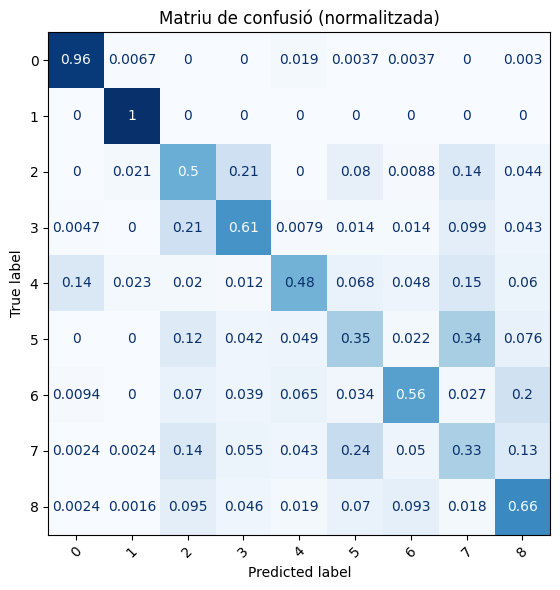

AttributeError: 'NoneType' object has no attribute 'savefig'

In [ ]:
# 📌 Paràmetres generals
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 128
NUM_CLASSES = {
    "pathmnist": 9,
    "chestmnist": 14,
    "organamnist": 11
}
DATASETS = ["pathmnist", "chestmnist", "organamnist"]

# 📂 Crear carpetes si cal
for ds in DATASETS:
    os.makedirs(f"annexos/metrics/{ds}", exist_ok=True)

# 🔁 Avaluació de models ja entrenats
for dataset in DATASETS:
    print(f"\n📁 Avaluant {dataset.upper()}")
    class_names = [str(i) for i in range(NUM_CLASSES[dataset])]

    multilabel = dataset == "chestmnist"
    criterion = nn.BCEWithLogitsLoss() if multilabel else nn.CrossEntropyLoss()

    # 🔄 Carregar model i dades
    model = DWTFormer(num_classes=NUM_CLASSES[dataset]).to(DEVICE)
    model.load_state_dict(torch.load(f"model/dwtformer_{dataset}.pt", map_location=DEVICE))
    model.eval()

    _, _, test_loader = load_medmnist_dataset(dataset, batch_size=BATCH_SIZE)

    # 📊 Avaluació
    test_loss, y_true, y_pred, y_scores = evaluate_model(
        model, test_loader, criterion, DEVICE, multilabel=multilabel
    )

    print(f"Test Loss: {test_loss:.4f}")
    print_f1_per_class(y_true, y_pred, class_names=class_names)

    if not multilabel:
        # 🔷 Matriu de confusió
        fig1 = plot_confusion(y_true, y_pred, class_names=class_names)
        fig1.savefig(f"annexos/metrics/{dataset}/confusion_matrix.png")
        plt.close(fig1)

        # 🔷 Corba ROC
        fig2 = plot_multiclass_roc(
            y_true, y_scores,
            n_classes=NUM_CLASSES[dataset],
            class_names=class_names
        )
        fig2.savefig(f"annexos/metrics/{dataset}/roc_curve_multiclass.png")
        plt.close(fig2)

    else:
        # 🔶 ROC-AUC per classe
        from sklearn.metrics import roc_auc_score

        roc_auc = roc_auc_score(y_true, y_scores, average=None)

        plt.figure(figsize=(10, 5))
        sns.barplot(x=class_names, y=roc_auc)
        plt.title(f"🔍 ROC-AUC per classe - {dataset.upper()}")
        plt.ylabel("AUC")
        plt.xlabel("Classes")
        plt.tight_layout()
        plt.savefig(f"annexos/metrics/{dataset}/roc_auc_per_class.png")
        plt.close()

        # 🔶 Heatmap de mètriques
        report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True, zero_division=0)
        df = pd.DataFrame(report).transpose().iloc[:NUM_CLASSES[dataset]]

        plt.figure(figsize=(10, 5))
        sns.heatmap(df[['precision', 'recall', 'f1-score']], annot=True, cmap="Blues", fmt=".2f")
        plt.title(f"📊 F1, Precision i Recall per classe - {dataset.upper()}")
        plt.tight_layout()
        plt.savefig(f"annexos/metrics/{dataset}/classification_metrics_heatmap.png")
        plt.close()

    print(f"✅ Resultats guardats per {dataset}")
